In [66]:
!pip install seaborn sklearn miceforest catboost

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [9]:
#standard
import re
from collections import Counter

#3rd party
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 50
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import miceforest as mf

import catboost

#local
from configs import DATA_PATH

SEED = 1998
np.random.seed(SEED)

In [10]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

from itertools import cycle

# Load data

In [11]:
data = pd.read_csv(DATA_PATH, index_col=0)
# data = data.drop(columns="void()")

print(len(data)-len(data.dropna()))

1462


In [4]:
# data.columns = [re.sub("\(\)", "", column) for column in data.columns]
# data.columns = [re.sub("\-|\,", "_", column) for column in data.columns]

data[["Activity", "subject"]] = data[["Activity", "subject"]].astype("category")

In [5]:
X, y = data.iloc[:,1:], data.iloc[:,0]

In [6]:
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in data.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

,count
fBodyAcc,82
fBodyGyro,79
fBodyAccJerk,79
tBodyGyro,43
tGravityAcc,40
tBodyGyroJerk,40
tBodyAccJerk,40
tBodyAcc,40
tBodyAccMag,13
tBodyAccJerkMag,13


In [7]:
a = data["Activity"].value_counts()

In [8]:
data["void()"].unique()

array([ 1.,  2.,  3., nan])

As we can see void() is almost uniformly distributed for some of the activities.

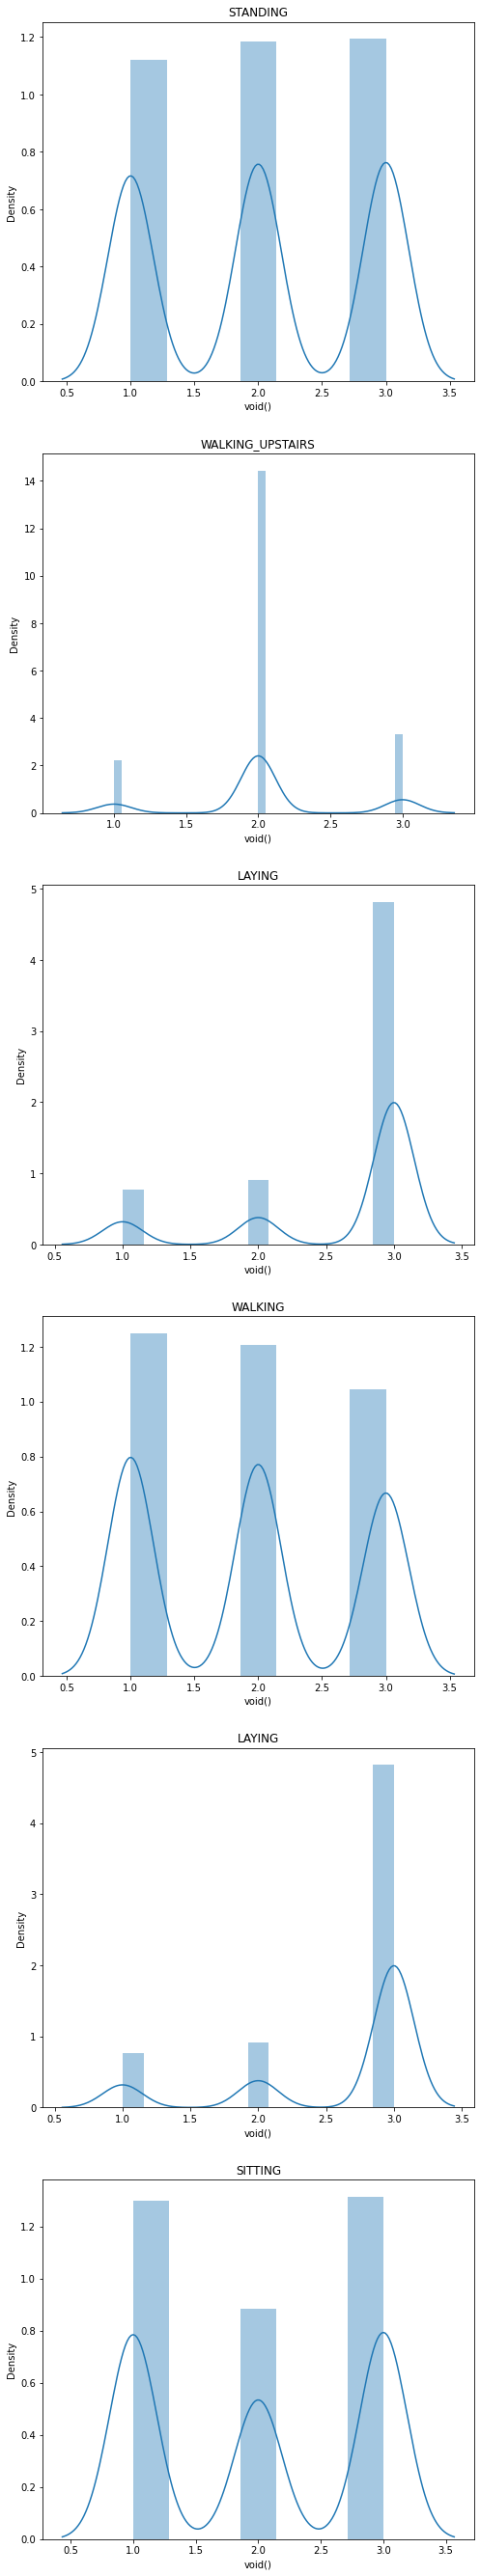

In [9]:
n = data["Activity"].nunique()
fig, ax = plt.subplots(n, 1, figsize=(8, n*8))
for axi, actv in zip(ax, data["Activity"]):
    sns.distplot(data.loc[data["Activity"]==actv, "void()"], ax=axi, kde=True)
    axi.set_title(actv)
    
plt.show()    

In [10]:
X.drop(columns="void()", inplace=True)

In [11]:
[col for col in X.columns if "-low()-" in col]

['tBodyGyro-low()-X', 'tBodyGyro-low()-Y', 'tBodyGyro-low()-Z']

In [12]:
X.drop(columns=['tBodyGyro-low()-X',
 'tBodyGyro-low()-Z',
 'tBodyGyro-low()-Y',
 'fBodyAcc-main()-Y',
 'fBodyAcc-main()-Z',
 'fBodyAcc-main()-X',
 'shadow-gravity-angle()',
 'energy-mean()'], inplace=True)

In [74]:
a = pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in X.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

In [75]:
a.sum()

count    562
dtype: int64

# Exploratory data analysis

Nans checkout

In [13]:
X.isna().sum().sort_values(ascending=False)

fBodyGyro-bandsEnergy()-33,48    84
fBodyAcc-bandsEnergy()-49,56     79
tBodyAccMag-sma()                77
fBodyAccJerk-std()-Y             77
fBodyAccMag-iqr()                76
                                 ..
fBodyBodyGyroMag-entropy()       41
tGravityAccMag-entropy()         41
tGravityAcc-std()-X              40
fBodyAcc-entropy()-Y             38
subject                           0
Length: 562, dtype: int64

In [14]:
nans_sorted = X.T.isna().sum().sort_values(ascending=False)
nans_sorted[nans_sorted > 0]

3036    40
6220    40
6796    40
8866    40
5397    40
        ..
2203     5
3233     4
3910     4
8877     4
8317     4
Length: 1462, dtype: int64

In [15]:
idx = nans_sorted[nans_sorted == 40].index[0]

In [16]:
X.loc[6220, :]

angle(X,gravityMean)                   -1.574029
angle(Y,gravityMean)                   -0.766164
angle(Z,gravityMean)                   -2.446730
angle(tBodyAccJerkMean),gravityMean)   -1.949025
angle(tBodyAccMean,gravity)            -0.113787
                                          ...   
tGravityAccMag-max()                    1.713235
tGravityAccMag-mean()                  -0.809719
tGravityAccMag-min()                   -0.478636
tGravityAccMag-sma()                    0.722631
tGravityAccMag-std()                   -0.668744
Name: 6220, Length: 562, dtype: float64

Cardinality checkout

In [17]:
data["Activity"].unique()

['STANDING', 'WALKING_UPSTAIRS', 'LAYING', 'WALKING', 'SITTING', 'WALKING_DOWNSTAIRS']
Categories (6, object): ['STANDING', 'WALKING_UPSTAIRS', 'LAYING', 'WALKING', 'SITTING', 'WALKING_DOWNSTAIRS']

In [18]:
pd.DataFrame(X.nunique().sort_values(ascending=False)).T

,tGravityAccMag-sma(),tGravityAccMag-mad(),"tBodyAccJerk-arCoeff()-X,1",tBodyAcc-mean()-Z,fBodyGyro-mad()-Z,fBodyAccJerk-kurtosis()-X,"tBodyGyro-arCoeff()-Y,2",fBodyAcc-skewness()-Z,tBodyGyro-std()-Y,"tBodyGyroJerk-arCoeff()-X,2","tBodyGyro-correlation()-Y,Z",fBodyAcc-meanFreq()-Y,tBodyAccJerk-mean()-Y,fBodyAccJerk-max()-Y,tBodyGyroMag-arCoeff()3,fBodyGyro-skewness()-Z,tBodyAcc-sma(),fBodyGyro-iqr()-Y,"tGravityAcc-arCoeff()-Z,3",tBodyAcc-std()-X,tBodyGyroMag-std(),"tBodyGyroJerk-arCoeff()-Z,4",fBodyAccJerk-skewness()-X,"tBodyAcc-arCoeff()-Z,3",fBodyAccMag-mean(),"tBodyAcc-correlation()-X,Z",fBodyAcc-mean()-Z,fBodyAcc-kurtosis()-Z,fBodyGyro-kurtosis()-X,fBodyGyro-mad()-X,tBodyAccMag-arCoeff()2,fBodyBodyGyroJerkMag-kurtosis(),fBodyGyro-max()-Y,fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-mean(),"tBodyAcc-arCoeff()-X,3",fBodyAccMag-skewness(),"tBodyGyroJerk-arCoeff()-Y,1",tBodyGyroJerk-mean()-X,"tBodyGyroJerk-arCoeff()-X,1",tBodyAccMag-mean(),"tBodyGyro-arCoeff()-Z,4",fBodyAccJerk-min()-Y,"tBodyGyro-arCoeff()-Z,1",fBodyAccJerk-meanFreq()-Y,tGravityAcc-sma(),"tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyAcc-iqr()-Z,fBodyGyro-std()-X,tBodyGyroJerkMag-iqr(),fBodyAcc-max()-Z,"tBodyGyro-arCoeff()-Y,1",tBodyGyroJerk-iqr()-Z,"tGravityAcc-correlation()-Y,Z",fBodyAcc-min()-Z,fBodyGyro-meanFreq()-Y,fBodyAccJerk-skewness()-Z,tBodyGyroMag-sma(),fBodyBodyGyroJerkMag-mad(),"angle(Y,gravityMean)",tBodyGyroJerk-sma(),tBodyGyro-mad()-Y,"tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,1","tBodyGyro-arCoeff()-X,2",fBodyGyro-meanFreq()-X,tBodyAccJerkMag-iqr(),"tBodyAcc-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3",tBodyAccJerkMag-arCoeff()4,"tBodyAcc-arCoeff()-Y,1",tBodyAccJerk-std()-Z,tBodyAccJerk-mean()-X,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,"tBodyGyroJerk-correlation()-X,Z",tBodyGyro-iqr()-Z,tBodyGyroJerk-std()-Z,tBodyAccMag-iqr(),tGravityAcc-mean()-X,tBodyGyroJerkMag-arCoeff()2,tBodyGyroJerkMag-arCoeff()4,fBodyAccJerk-min()-X,fBodyBodyGyroMag-sma(),fBodyAccJerk-meanFreq()-Z,fBodyBodyGyroJerkMag-skewness(),tBodyGyro-mad()-X,tBodyGyroJerkMag-arCoeff()1,tGravityAcc-energy()-Z,tBodyGyro-mean()-Z,"tBodyAccJerk-arCoeff()-Z,1",tBodyGyro-mean()-X,tBodyGyro-mad()-Z,tGravityAcc-energy()-X,tBodyAccJerk-mad()-Y,tBodyAcc-std()-Y,fBodyAcc-min()-Y,tGravityAcc-std()-X,tGravityAccMag-arCoeff()1,tBodyAccJerkMag-sma(),"tBodyGyro-arCoeff()-Y,3","angle(tBodyGyroJerkMean,gravityMean)","angle(Z,gravityMean)","tGravityAcc-arCoeff()-Z,2",fBodyGyro-mean()-X,"tBodyAcc-arCoeff()-X,2",fBodyBodyGyroMag-kurtosis(),tBodyAcc-iqr()-X,tBodyAcc-mean()-Y,tBodyGyroMag-mean(),fBodyGyro-iqr()-X,fBodyBodyGyroMag-meanFreq(),fBodyGyro-std()-Z,fBodyBodyGyroMag-skewness(),"tBodyGyroJerk-correlation()-Y,Z",tBodyAccJerk-mean()-Z,fBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Y,fBodyAcc-std()-X,fBodyBodyAccJerkMag-skewness(),fBodyBodyGyroJerkMag-min(),fBodyAcc-mad()-Z,fBodyAcc-mad()-Y,fBodyAcc-iqr()-Z,fBodyAcc-iqr()-Y,"tBodyGyro-arCoeff()-X,4",fBodyGyro-meanFreq()-Z,fBodyGyro-mad()-Y,fBodyBodyAccJerkMag-mean(),tGravityAcc-iqr()-Z,fBodyGyro-max()-X,tBodyAcc-mad()-Z,fBodyAccMag-meanFreq(),"tBodyGyroJerk-arCoeff()-X,3","tBodyGyroJerk-arCoeff()-Y,2","tGravityAcc-arCoeff()-X,3","tBodyAccJerk-arCoeff()-Z,3",fBodyAccMag-mad(),tBodyGyro-std()-Z,"tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3",fBodyAccJerk-min()-Z,fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-mean(),fBodyBodyAccJerkMag-iqr(),fBodyBodyAccJerkMag-max(),"tBodyGyroJerk-arCoeff()-Z,2",tBodyAcc-std()-Z,fBodyGyro-min()-Y,"tBodyAccJerk-correlation()-X,Y",fBodyAcc-kurtosis()-Y,fBodyAcc-mad()-X,fBodyBodyGyroMag-std(),fBodyAccJerk-kurtosis()-Y,fBodyAccJerk-mean()-X,fBodyBodyGyroJerkMag-meanFreq(),tBodyAccJerkMag-arCoeff()3,tGravityAccMag-std(),tGravityAcc-std()-Y,tBodyGyro-mean()-Y,tGravityAcc-mad()-Y,"tGravityAcc-arCoeff()-Z,4","tBodyGyro-correlation()-X,Z",tGravityAcc-mean()-Y,"tGravityAcc-arCoeff()-Y,4",tGravityAccMag-iqr(),"tBodyGyroJerk-arCoeff()-X,4",tGravityAccMag-arCoeff()4,"tBodyAcc-arC

### Subjects checkout

In [19]:
X["subject"].nunique()

30

In [20]:
X.nunique().sort_values(ascending=True)

fBodyAcc-maxInds-Y              23
fBodyAcc-maxInds-Z              25
fBodyGyro-maxInds-Z             25
fBodyGyro-maxInds-X             26
fBodyGyro-maxInds-Y             27
                              ... 
fBodyGyro-mad()-Z             6572
tBodyAcc-mean()-Z             6573
tBodyAccJerk-arCoeff()-X,1    6573
tGravityAccMag-mad()          8577
tGravityAccMag-sma()          8615
Length: 562, dtype: int64

### Plot activity on number of occurances per subject 

In [21]:
subjects_count = data[["subject","Activity"]].groupby(["subject"]).count().reset_index()

In [22]:
subjects_groups = data[["subject","Activity", "energy-mean()" ]].groupby(["subject", "Activity"]).count().reset_index()

In [23]:
activities_subjects = data[["subject","Activity"]].groupby(["Activity"]).count().reset_index()

In [24]:
subjects_groups

,subject,Activity,energy-mean()
0,1,LAYING,19
1,1,SITTING,51
2,1,STANDING,42
3,1,WALKING,103
4,1,WALKING_DOWNSTAIRS,55
...,...,...,...
175,30,SITTING,60
176,30,STANDING,44
177,30,WALKING,67
178,30,WALKING_DOWNSTAIRS,69


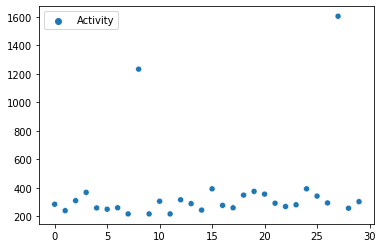

In [25]:
subjects_sorted = subjects_count.sort_index()
sns.scatterplot(data=subjects_sorted)
plt.show()

In [26]:
subjects_groups["subject"].nunique()

30

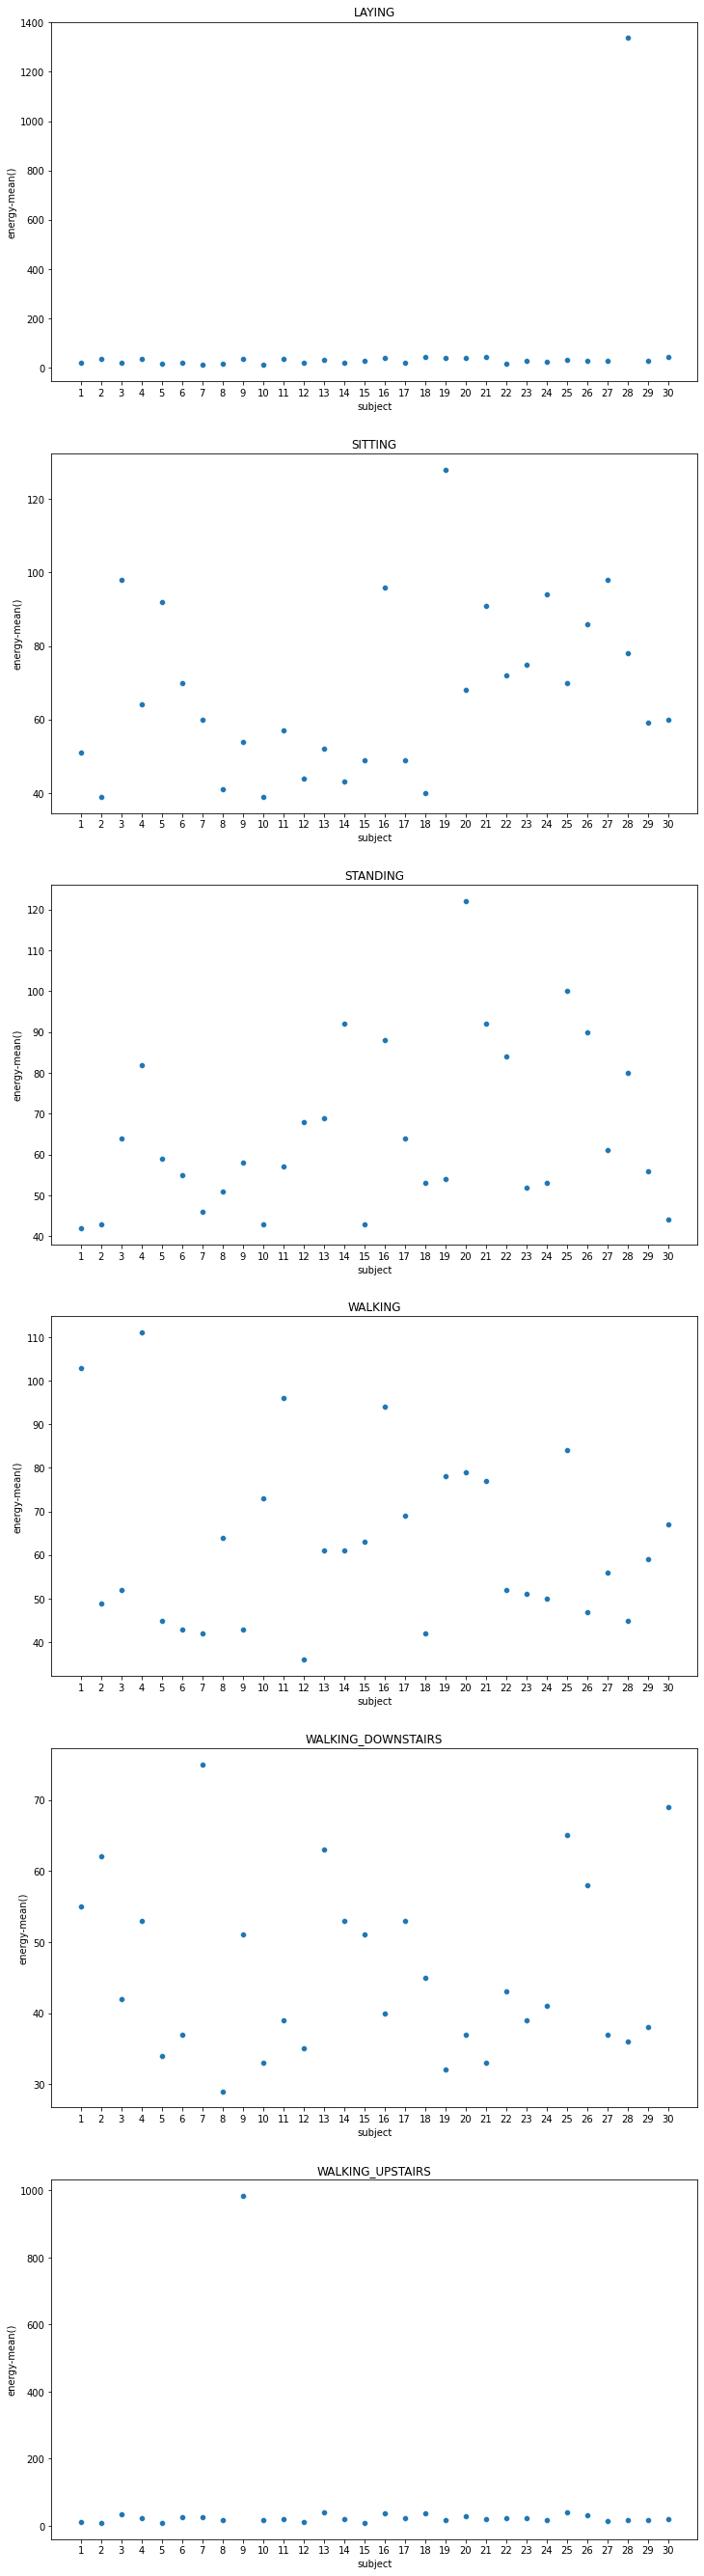

In [27]:
n = len(subjects_groups["Activity"].unique())

fix, ax = plt.subplots(n, 1, figsize=(12, len(subjects_groups["Activity"].unique())*8))

for axi, activity in zip(ax, subjects_groups["Activity"].unique()):
    sns.scatterplot(x="subject", y="energy-mean()", data=subjects_groups[subjects_groups["Activity"]==activity], ax=axi)
    axi.set_xticks(np.arange(1, subjects_groups["subject"].nunique()+1))
    axi.set_title(activity)

plt.show()

In [28]:
subjects_groups

,subject,Activity,energy-mean()
0,1,LAYING,19
1,1,SITTING,51
2,1,STANDING,42
3,1,WALKING,103
4,1,WALKING_DOWNSTAIRS,55
...,...,...,...
175,30,SITTING,60
176,30,STANDING,44
177,30,WALKING,67
178,30,WALKING_DOWNSTAIRS,69


### Data imputation

In [29]:
data.shape

(11086, 572)

Reorder data to get subject and activity on the end

In [30]:
columns = list(X_sample.columns)
columns.remove("subject")
columns.extend(["subject"])

X_sample = X_sample[columns]

Get dummies

In [31]:
X_w_dummies = pd.get_dummies(X_sample, columns=["subject"], drop_first=True)
X_w_dummies[X_w_dummies.columns[-30:]].head(2)

,void(),subject_2,subject_3,subject_4,subject_5,subject_6,subject_7,subject_8,subject_9,subject_10,subject_11,subject_12,subject_13,subject_14,subject_15,subject_16,subject_17,subject_18,subject_19,subject_20,subject_21,subject_22,subject_23,subject_24,subject_25,subject_26,subject_27,subject_28,subject_29,subject_30
5451,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1607,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
imputer = KNNImputer(n_neighbors=5, weights="distance")
for subject in data["subject"].unique():
    X.loc[X["subject"]==subject, :] = imputer.fit_transform(X.loc[X["subject"]==subject, :])

### Basic statistics

In [33]:
summary = ss.describe(X, axis=0, nan_policy="omit")[1:]
#min, max columns
min_col, max_col = summary[0][0], summary[0][1]

summary = pd.DataFrame([min_col, max_col, *summary[1:]], columns=X.columns).T
summary.columns = ["min","max", "mean", "variance", "skewness", "kurtosis"]
summary

,min,max,mean,variance,skewness,kurtosis
"angle(X,gravityMean)",-1.577122,-1.536682,-1.566809,0.000098,1.331589,0.154112
"angle(Y,gravityMean)",-1.839413,0.720197,-0.615404,0.109175,1.198157,1.231235
"angle(Z,gravityMean)",-2.562914,-2.345198,-2.446156,0.001132,0.814693,0.096064
"angle(tBodyAccJerkMean),gravityMean)",-2.012415,-1.714677,-1.860163,0.004962,0.135956,-0.833199
"angle(tBodyAccMean,gravity)",-0.702915,0.845884,0.090580,0.056678,-0.219480,1.596954
...,...,...,...,...,...,...
tGravityAccMag-max(),-0.562940,3.324141,2.499520,0.788978,-0.596500,-1.031492
tGravityAccMag-mean(),-0.945475,-0.665371,-0.884647,0.004111,0.436359,-1.408365
tGravityAccMag-min(),-1.044689,1.335166,-0.815301,0.071160,0.892543,-0.036250
tGravityAccMag-sma(),-2.490387,3.790841,1.184465,5.438169,-0.450480,-1.451277


In [34]:
summary.sort_values("kurtosis", ascending=False)

,min,max,mean,variance,skewness,kurtosis
"fBodyAccJerk-bandsEnergy()-57,64",-1.956628,7.385268,7.320365,0.061938,-14.456347,372.576194
"fBodyGyro-bandsEnergy()-33,40.1",0.710108,3.800883,3.768280,0.007562,-12.677921,320.729501
tGravityAcc-iqr()-X,2.481285,4.731822,4.692694,0.005091,-12.387636,277.241758
tGravityAcc-mad()-X,2.622598,4.072296,4.046607,0.002120,-12.044690,255.471189
tBodyAcc-mean()-Y,-3.983011,1.082304,-0.953227,0.006915,-2.943041,246.457233
...,...,...,...,...,...,...
fBodyAccMag-entropy(),1.910602,3.805075,3.048851,0.416170,-0.152223,-1.786134
tBodyAccJerk-entropy()-X,4.576505,9.059646,6.927760,2.143606,-0.127269,-1.786225
fBodyAcc-entropy()-X,-4.577129,0.086024,-1.776681,2.711401,-0.158124,-1.801606
fBodyAccJerk-entropy()-X,2.747233,4.097324,3.609495,0.251141,-0.237223,-1.828867


In [35]:
list(filter(lambda x: "angle" in x, data.columns))

['angle(X,gravityMean)',
 'angle(Y,gravityMean)',
 'angle(Z,gravityMean)',
 'angle(tBodyAccJerkMean),gravityMean)',
 'angle(tBodyAccMean,gravity)',
 'angle(tBodyGyroJerkMean,gravityMean)',
 'angle(tBodyGyroMean,gravityMean)',
 'shadow-gravity-angle()']

In [36]:
np.abs(data[list(filter(lambda x: "f" in x, data.columns))].corrwith(data["shadow-gravity-angle()"])).sort_values(ascending=False)

fBodyAccJerk-bandsEnergy()-9,16       0.345174
tBodyGyro-arCoeff()-Y,1               0.343905
fBodyGyro-min()-Z                     0.332938
fBodyAcc-bandsEnergy()-9,16           0.329111
fBodyGyro-meanFreq()-Y                0.325428
                                        ...   
tBodyGyro-arCoeff()-X,2               0.003923
fBodyAccJerk-bandsEnergy()-33,48.2    0.003446
fBodyGyro-min()-X                     0.002638
fBodyAccJerk-bandsEnergy()-17,32      0.002223
fBodyAccJerk-bandsEnergy()-25,48      0.001964
Length: 372, dtype: float64

In [37]:
sorted(list(filter(lambda x: "bandsEnergy" in x, X.columns)))

['fBodyAcc-bandsEnergy()-1,16',
 'fBodyAcc-bandsEnergy()-1,16.1',
 'fBodyAcc-bandsEnergy()-1,16.2',
 'fBodyAcc-bandsEnergy()-1,24',
 'fBodyAcc-bandsEnergy()-1,24.1',
 'fBodyAcc-bandsEnergy()-1,24.2',
 'fBodyAcc-bandsEnergy()-1,8',
 'fBodyAcc-bandsEnergy()-1,8.1',
 'fBodyAcc-bandsEnergy()-1,8.2',
 'fBodyAcc-bandsEnergy()-17,24',
 'fBodyAcc-bandsEnergy()-17,24.1',
 'fBodyAcc-bandsEnergy()-17,24.2',
 'fBodyAcc-bandsEnergy()-17,32',
 'fBodyAcc-bandsEnergy()-17,32.1',
 'fBodyAcc-bandsEnergy()-17,32.2',
 'fBodyAcc-bandsEnergy()-25,32',
 'fBodyAcc-bandsEnergy()-25,32.1',
 'fBodyAcc-bandsEnergy()-25,32.2',
 'fBodyAcc-bandsEnergy()-25,48',
 'fBodyAcc-bandsEnergy()-25,48.1',
 'fBodyAcc-bandsEnergy()-25,48.2',
 'fBodyAcc-bandsEnergy()-33,40',
 'fBodyAcc-bandsEnergy()-33,40.1',
 'fBodyAcc-bandsEnergy()-33,40.2',
 'fBodyAcc-bandsEnergy()-33,48',
 'fBodyAcc-bandsEnergy()-33,48.1',
 'fBodyAcc-bandsEnergy()-33,48.2',
 'fBodyAcc-bandsEnergy()-41,48',
 'fBodyAcc-bandsEnergy()-41,48.1',
 'fBodyAcc-bandsE

### Euclidean
Calucluating euclidean distance as magnitude of force

In [80]:
xyz_bands_energy = np.array(sorted([column for column in X.columns if "bandsEnergy" in column])).reshape(-1, 3)

In [81]:
a = [col.split("-")[2].split(",") for col in xyz_bands_energy.flatten().tolist()]
coordinates = list(set([(xy[0], xy[1].split(".")[0]) for xy in a]))
coordinates

[('09', '16'),
 ('17', '24'),
 ('17', '32'),
 ('33', '48'),
 ('41', '48'),
 ('25', '32'),
 ('25', '48'),
 ('01', '16'),
 ('01', '24'),
 ('49', '56'),
 ('33', '40'),
 ('01', '08'),
 ('49', '64'),
 ('57', '64')]

In [82]:
coordinates_joined = [",".join(coor) for coor in coordinates]
coordinates_joined

['09,16',
 '17,24',
 '17,32',
 '33,48',
 '41,48',
 '25,32',
 '25,48',
 '01,16',
 '01,24',
 '49,56',
 '33,40',
 '01,08',
 '49,64',
 '57,64']

In [83]:
coordinates_changed = [(coordinate[0].zfill(2), coordinate[1].zfill(2)) for coordinate in coordinates]
coordinates_changed2 = [",".join(coor) for coor in coordinates_changed]
coordinates_dict = {j:c for j,c in zip(coordinates_joined, coordinates_changed2)}

In [84]:
cols = []
for column in X.columns:
    for key, value in coordinates_dict.items():
        if key in column:
            column = re.sub(key, value, column)
    cols.append(column)   

In [85]:
X.columns = cols

In [86]:
xyz_bands_energy = sorted([column for column in X.columns if "bandsEnergy" in column])

In [87]:
# xyz_bands_energy = list(filter(lambda x: x[0]!="f", xyz_bands_energy))
xyz_bands_energy = np.array(xyz_bands_energy).reshape(-1, 3)

In [109]:
X_euclid = X.copy()

In [110]:
for xyz in xyz_bands_energy:
    X_euclid[f"{xyz[0]}_euclid"] = (X_euclid[xyz] ** 2).sum(axis=1)
    X_euclid.drop(columns=xyz, inplace=True)

In [111]:
X_euclid.shape

(11086, 478)

### Tsne after euclid 

### Scale data

In [105]:
scaler = StandardScaler()
subjects = X_euclid["subject"].copy()

columns = X_euclid.columns
X_euclid = scaler.fit_transform(X_euclid)

X_euclid = pd.DataFrame(X_euclid, columns=columns)
X_euclid["subject"] = subjects

In [112]:
pca = PCA(n_components=0.9, random_state=3)

In [113]:
subjects = X_euclid["subject"].copy()

In [114]:
X_pca = X_euclid.drop(columns="subject")

In [116]:
values = pca.fit_transform(X_pca)

In [119]:
X_pca = pd.DataFrame(values)

In [122]:
X_pca["subject"] = subjects

In [123]:
X_pca.shape

(11086, 11)

In [124]:
X_euclid = X_pca

# Spliting dataset

In [130]:
y.unique().categories

Index(['STANDING', 'WALKING_UPSTAIRS', 'LAYING', 'WALKING', 'SITTING',
       'WALKING_DOWNSTAIRS'],
      dtype='object')

In [131]:
mapping = {cat:idx for idx, cat in enumerate(y.unique().categories)}
mapping

{'STANDING': 0,
 'WALKING_UPSTAIRS': 1,
 'LAYING': 2,
 'WALKING': 3,
 'SITTING': 4,
 'WALKING_DOWNSTAIRS': 5}

In [132]:
y = y.map(mapping)

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X_euclid, y, test_size=0.2)

# Training

In [134]:
cat_features = ["subject"]

In [135]:
classifier = catboost.CatBoostClassifier(task_type="GPU", devices="0")

In [136]:
classifier.fit(X_train, y_train, cat_features=cat_features, verbose=0)

In [137]:
y_hat = classifier.predict(X_test)

In [138]:
from sklearn.metrics import confusion_matrix

In [139]:
mapping

{'STANDING': 0,
 'WALKING_UPSTAIRS': 1,
 'LAYING': 2,
 'WALKING': 3,
 'SITTING': 4,
 'WALKING_DOWNSTAIRS': 5}

In [140]:
confusion_matrix(y_test, y_hat)

array([[337,   0,   0,   0,  74,   0],
       [  0, 314,   0,   8,   0,   5],
       [  5,   1, 382,   0,  16,   0],
       [  1,   2,   0, 375,   0,   9],
       [ 64,   1,  14,   0, 318,   0],
       [  0,   6,   0,  18,   0, 268]])

In [141]:
from sklearn.metrics import plot_confusion_matrix

Confusion matrix, without normalization
Normalized confusion matrix


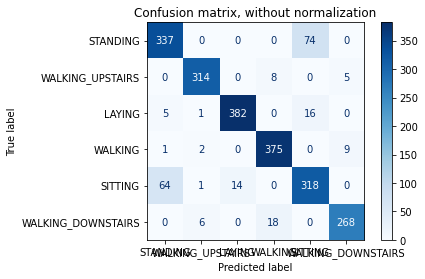

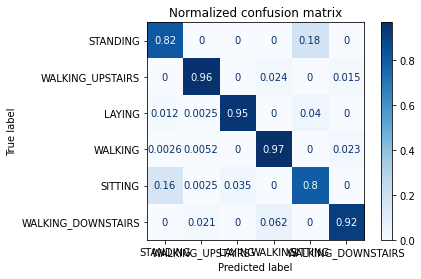

In [142]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=mapping.keys(),
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
#     print(disp.confusion_matrix)

plt.show()

In [143]:
from sklearn.metrics import accuracy_score

In [144]:
accuracy_score(y_test, y_hat)

0.8990081154192967

In [145]:
len(X_euclid.columns)

11

# Plot ROC

In [108]:
y_test_dummy = pd.get_dummies(y_test)[list(range(6))]
y_hat_dummy = pd.get_dummies(y_hat.flatten())
y_hat_dummy.index = y_test_dummy.index
y_test_dummy = y_test_dummy.sort_index()
y_hat_dummy = y_hat_dummy.sort_index()

In [109]:
y_test
y_hat
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y.nunique()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummy.iloc[:, i], y_hat_dummy.iloc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_dummy.values.ravel(), y_hat_dummy.values.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

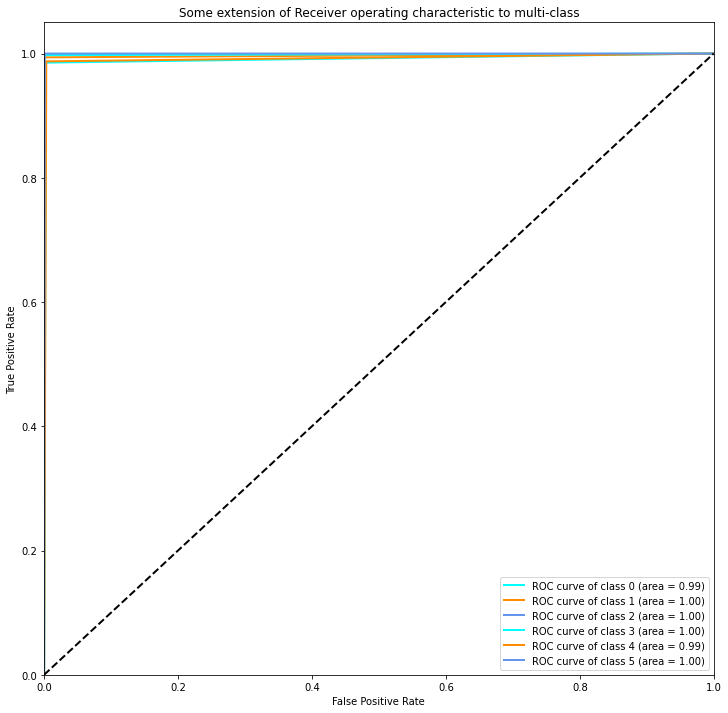

In [110]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2
# Plot all ROC curves
plt.figure(figsize=(12,12))
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()